In [2]:
import sys
sys.path.append("/tf/massimal/python/massimal/tools")

In [1]:
# Imports
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import skimage
# "Local import" from massimal repository (https://github.com/mh-skjelvareid/massimal)
import annotation, image_render, hyspec_io, misc, hyspec_stats
import importlib
#importlib.reload(hyspec_stats)

import sklearn.preprocessing
import sklearn.decomposition
import math

In [2]:
# Parameters
TILE_SHAPE = (128,128)
TEST_FRAC = 0.3
BATCH_SIZE = 8

In [12]:
arr = np.zeros((3,10,10))
arr[0][3:6,3:6] = 1
arr[2][7:9,3:9] = 1


In [17]:
np.count_nonzero(arr[0]) / np.size(arr[0])

0.09

In [16]:
np.size(arr[0])

100

In [13]:
print(arr)

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
  [0. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
  [0. 0. 0

In [31]:
# Function for extracting tiles
def labeled_image_to_tensor_tiles(image,labels,tile_shape,
                                  tile_strides=None,padding='SAME',
                                  min_labeled_fraction = 0.05):
    """ Split image and label mask into smaller tiles
    
    # Usage:
    (image_tiles,label_tiles) = ...
    
    # Input arguments:
    image:        3D numpy array with dimensions (rows, columns, channels)
    labels:       2D numpy array with dimensions (rows,columns)
    tile_shape:   Tuple of integers, (tile_rows, tile_cols)
    
    # Keyword arguments
    tile_strides: Tuple of integers, (row_stride, col_stride)
                  If None, set equal to tile_shape (no overlap between tiles)
    padding:      'VALID' or 'SAME' (see tensorflow.image.extract_patches)
                  Default: 'SAME'
    min_labeled_fraction:   Use this to filter out tiles with zero or low
                            number of labeled pixels. Set to zero to include all 
                            pixels.
    """
    
    if tile_strides is None: tile_strides = tile_shape
    
    image_tensor = tf.reshape(tf.convert_to_tensor(image),(1,)+image.shape)
    label_tensor = tf.reshape(tf.convert_to_tensor(labels),(1,)+labels.shape + (1,))
    
    sizes = [1,*tile_shape,1]
    strides = [1,*tile_strides,1]
    rates = [1,1,1,1]
    
    image_tiles = tf.image.extract_patches(image_tensor, sizes, strides, rates, padding=padding)
    image_tiles = tf.reshape(image_tiles,[-1,*tile_shape,image.shape[-1]])
    label_tiles = tf.image.extract_patches(label_tensor, sizes, strides, rates, padding=padding)
    label_tiles = tf.reshape(label_tiles,[-1,*tile_shape])
    
    # Filter out tiles with zero or few annotated pixels (optional)
    if min_labeled_fraction > 0:
        labeled_tiles_mask = np.array(
            [(np.count_nonzero(tile)/np.size(tile))>min_labeled_fraction for tile in label_tiles])
        image_tiles = tf.boolean_mask(image_tiles,labeled_tiles_mask)
        label_tiles = tf.boolean_mask(label_tiles,labeled_tiles_mask)
        
    return image_tiles, label_tiles


In [23]:
# Paths
json_gray = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_Grayscale/label_classes.json'
annotation_dir = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/Selected_Annotation_Images'
hyspec_dir = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4_Rad_Georef_SGC'

# json_gray = '/tf/massimal/data/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_Grayscale/label_classes.json'
# annotation_dir = '/tf/massimal/data/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/Selected_Annotation_Images'
# hyspec_dir = '/tf/massimal/data/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4_Rad_Georef_SGC'

In [24]:
# Find paths to annotated images
ann_file_paths_str = misc.file_pattern_search(annotation_dir,'*.png')
ann_file_paths = [pathlib.Path(fn) for fn in ann_file_paths_str]
for p in ann_file_paths:
    print(p.name)

OlbergholmenS_Pika_L_12-Radiance From Raw Data-Georectify Airborne Datacube.png
OlbergholmenS_Pika_L_15-Radiance From Raw Data-Georectify Airborne Datacube.png
OlbergholmenS_Pika_L_16-Radiance From Raw Data-Georectify Airborne Datacube.png
OlbergholmenS_Pika_L_17-Radiance From Raw Data-Georectify Airborne Datacube.png


In [25]:
# Read annotation metadata file, show classes
class_dict = annotation.read_hasty_metadata(json_gray)
for class_name,class_ind in class_dict.items():
    print(f'{class_name}: {class_ind}')

Sand: 1
Gravel: 2
Mud: 3
Terrestrial: 4
Zostera marina - dominant: 5
Zostera marina - normal: 6
Zostera marina - sparse: 7
Zostera marina with turf algae: 8
Turf algae - dominant: 9
Turf algae - normal: 10
Turf algae - sparse: 11
Rockweed: 12
Rockweed with turf algae: 13
Fucus serratus: 14
Aegagropila (algae ball): 15
Mixed algae classes on soft substrate: 16
Saccharina latissima: 17


In [26]:
# Define classes to keep / merge
classes_to_merge = [['Sand'],
                    ['Zostera marina - dominant', 'Zostera marina - normal', 'Zostera marina - sparse'],
                    ['Zostera marina with turf algae']]
merged_class_names = ['Sand', 'Zostera marina', 'Zostera marina with turf algae']

In [34]:
# Loop through images, spilt into tiles
hyspec_tiles = []
annotation_tiles = []
for annotation_file in ann_file_paths:
    # Load hyperspectral image
    hyspec_file = pathlib.Path(hyspec_dir) / (annotation_file.stem + '.bip.hdr')
    hyspec_image, wl, rgb_ind, metadata = hyspec_io.load_envi_image(hyspec_file)
    # Load annotation image
    class_mask = skimage.io.imread(annotation_file)
    class_mask[np.all(hyspec_image==0,axis=2)] = 0        # Don't include zero data
    
    # Merge classes
    merged_class_dict, merged_class_mask = annotation.merge_classes_with_mask(class_dict,class_mask,classes_to_merge,merged_class_names)
    merged_class_dict, merged_class_mask = annotation.extract_subset(merged_class_dict,merged_class_mask,merged_class_names)
    
    # Extract tiles
    X_tiles, y_tiles = labeled_image_to_tensor_tiles(hyspec_image,merged_class_mask,TILE_SHAPE,padding='VALID',
                                                    min_labeled_fraction=0.05)
    hyspec_tiles.append(X_tiles)
    annotation_tiles.append(y_tiles)

# Concatenate into single tensors
hyspec_tiles = tf.concat(hyspec_tiles,axis=0)
annotation_tiles = tf.concat(annotation_tiles,axis=0)

# Show tensor sizes
print(f'{hyspec_tiles.shape=},\n{annotation_tiles.shape=}')

hyspec_tiles.shape=TensorShape([69, 128, 128, 173]),
annotation_tiles.shape=TensorShape([69, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


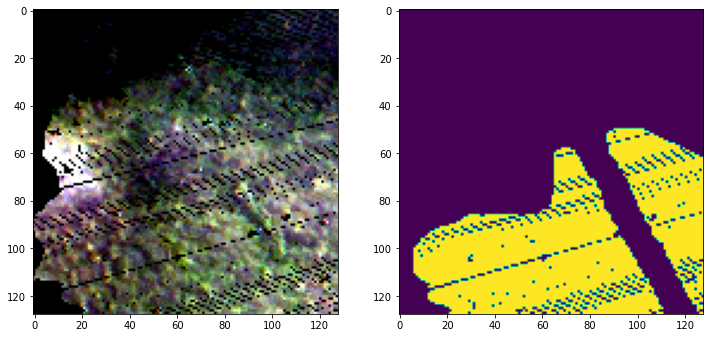

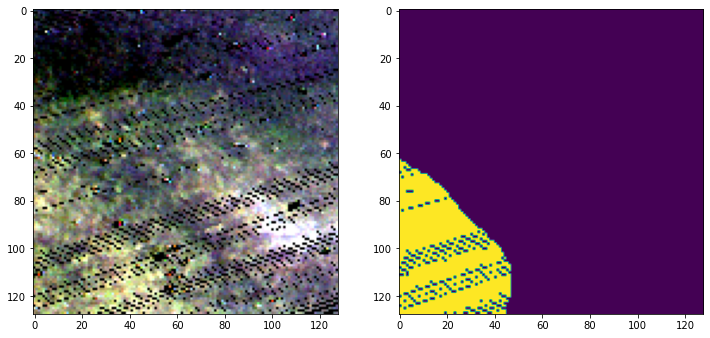

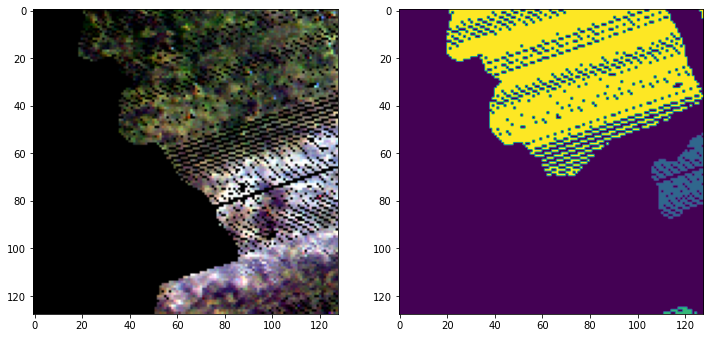

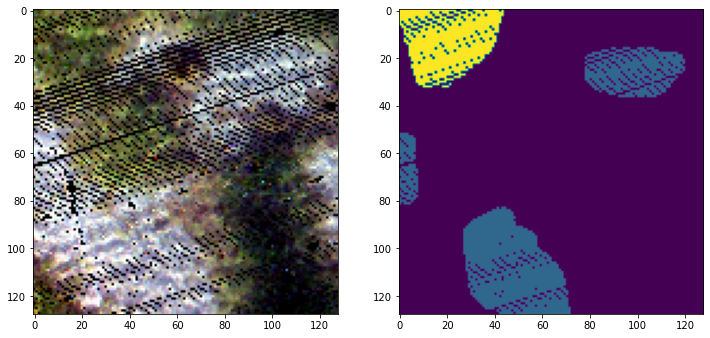

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


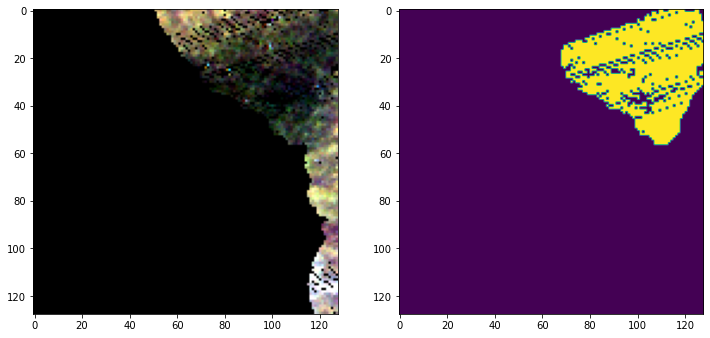

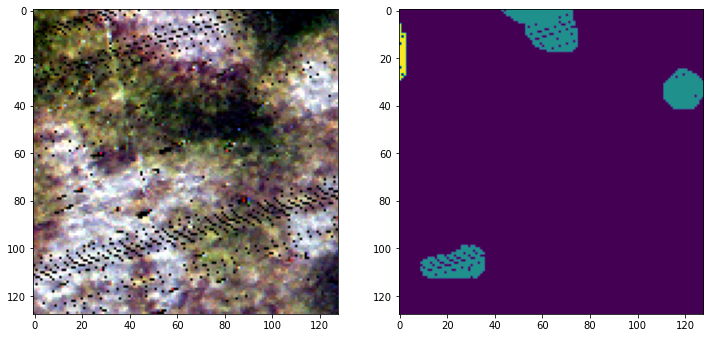

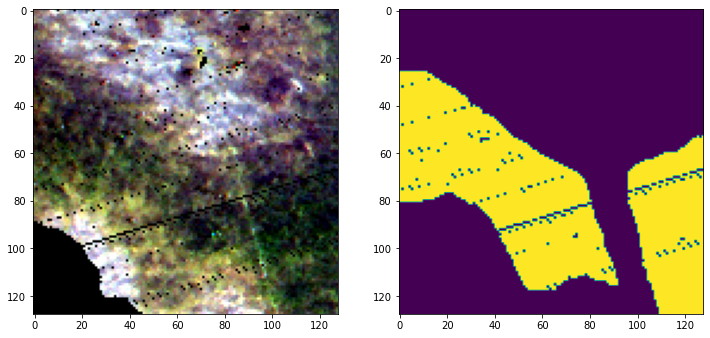

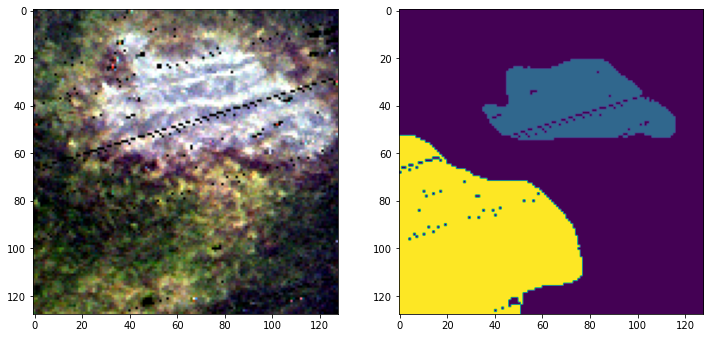

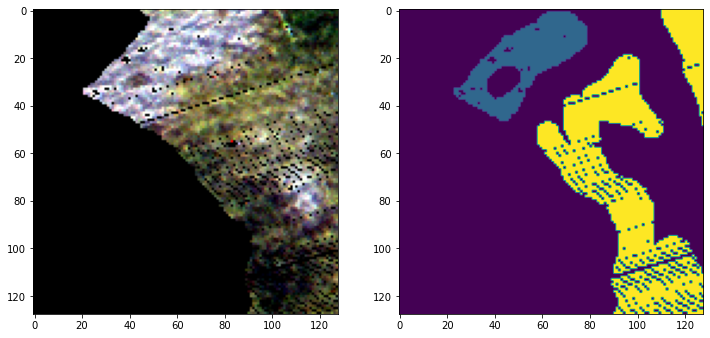

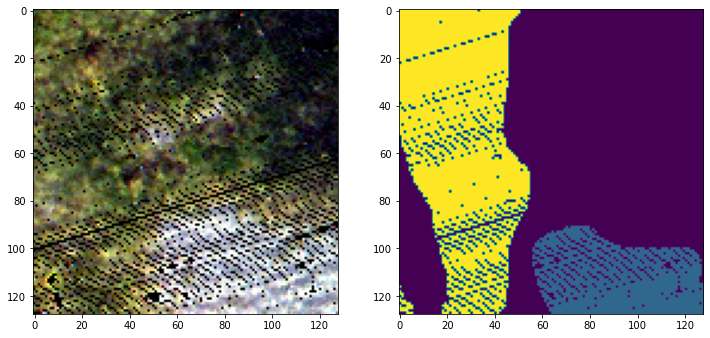

In [35]:
# Show example tiles with annotation
for i in range(10):
    fig,ax = plt.subplots(1,2,figsize=(12,6))
    ax[0].imshow(image_render.percentile_stretch(np.array(hyspec_tiles[i])[:,:,rgb_ind]))
    ax[1].imshow(np.array(annotation_tiles[i]))
    plt.show()